In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Kangaroo.csv')

In [3]:
df_cleaned = df.drop(columns=["Unnamed: 0", "url"])
str_cols = df_cleaned.select_dtypes(include='object').columns #Selects columns that are of type string or mixed object
for col in str_cols:
    df_cleaned[col] = df_cleaned[col].apply(lambda x: x.strip() if isinstance(x, str) else x)

df_cleaned.describe(include='all') # Summary statistics of the data

,id,type,subtype,bedroomCount,bathroomCount,province,locality,postCode,habitableSurface,roomCount,...,hasOffice,toiletCount,hasSwimmingPool,hasFireplace,hasTerrace,terraceSurface,terraceOrientation,accessibleDisabledPeople,epcScore,price
count,8.036800e+04,80368,80368,73558.000000,66672.000000,80368,80368,80368.000000,67783.000000,21948.000000,...,10387,55094.00000,1816,3044,47429,28599.000000,11262,0.0,65391,7.637000e+04
unique,NaN,4,26,NaN,NaN,11,5470,NaN,NaN,NaN,...,1,NaN,1,1,1,NaN,8,NaN,20,NaN
top,NaN,HOUSE,HOUSE,NaN,NaN,West Flanders,Antwerpen,NaN,NaN,NaN,...,True,NaN,True,True,True,NaN,SOUTH,NaN,B,NaN
freq,NaN,45234,33977,NaN,NaN,15515,1665,NaN,NaN,NaN,...,10387,NaN,1816,3044,47429,NaN,3143,NaN,13243,NaN
mean,1.952922e+07,NaN,NaN,3.008877,1.427121,NaN,NaN,5266.587199,178.499993,7.110443,...,NaN,1.80624,NaN,NaN,NaN,24.512710,NaN,NaN,NaN,4.476061e+05
std,2.897688e+06,NaN,NaN,1.833185,4.556189,NaN,NaN,3045.698904,820.878936,5.824088,...,NaN,8.41452,NaN,NaN,NaN,43.244643,NaN,NaN,NaN,5.115757e+05
min,1.882546e+06,NaN,NaN,1.000000,1.000000,NaN,NaN,1000.000000,6.000000,1.000000,...,NaN,1.00000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,3.141000e+03
25%,2.035055e+07,NaN,NaN,2.000000,1.000000,NaN,NaN,2330.000000,93.000000,1.000000,...,NaN,1.00000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,2.300000e+05
50%,2.052985e+07,NaN,NaN,3.000000,1.000000,NaN,NaN,4830.000000,140.000000,6.000000,...,NaN,2.00000,NaN,NaN,NaN,15.000000,NaN,NaN,NaN,3.299000e+05
75%,2.061494e+07,NaN,NaN,4.000000,2.000000,NaN,NaN,8420.000000,200.000000,11.000000,...,NaN,2.00000,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,4.790000e+05


In [4]:
#Delete all rows wihout price
df_cleaned = df_cleaned.dropna(subset=['price'])

### How to Decide: Keep or Drop the swimmingPool Column?
1. Missing values: 97.740394
2. Filter the top 10% most expensive houses
3. Do Spearman correlation
4. Compare Mean Price: compare average price for properties with and without a swimming pool
5. Test Statistical Significance: if p_value < 0.05, then the price difference is statistically significant → keep the feature.
Conclusion: should keep it


### Filter the top 10% most expensive houses:

Selects the top 10% most expensive properties (based on the 90th percentile of price).

Counts how many of those have hasSwimmingPool = True, and how many are missing (NaN).

In [5]:
#Filter the top 10% most expensive houses:
top_10 = df_cleaned[df_cleaned['price'] >= df_cleaned['price'].quantile(0.90)]
top_10['hasSwimmingPool'].value_counts(dropna=False)

hasSwimmingPool
NaN     6730
True     941
Name: count, dtype: int64

In [6]:
### Do Spearman correlation

In [7]:
df_cleaned['hasSwimmingPool'] = df_cleaned['hasSwimmingPool'].fillna(0) # filling missing values (NaNs) in hasSwimmingPool with 0
df_cleaned['swimmingPool_missing'] = df['hasSwimmingPool'].isna().astype(int) # new column that explicitly tracks which values were originally missing: 1: missing

print(df_cleaned[['price', 'hasSwimmingPool', 'swimmingPool_missing']].corr(method='spearman'))

                        price  hasSwimmingPool  swimmingPool_missing
price                 1.00000          0.17196              -0.17196
hasSwimmingPool       0.17196          1.00000              -1.00000
swimmingPool_missing -0.17196         -1.00000               1.00000


In [8]:
# Compare Mean Price
df_swim = df_cleaned.copy()
df_swim['swimmingPool_filled'] = df_swim['hasSwimmingPool'].fillna(0)

# Group by 0 and 1
df_swim.groupby('swimmingPool_filled')['price'].mean()

swimmingPool_filled
0       4.265138e+05
True    1.313528e+06
Name: price, dtype: float64

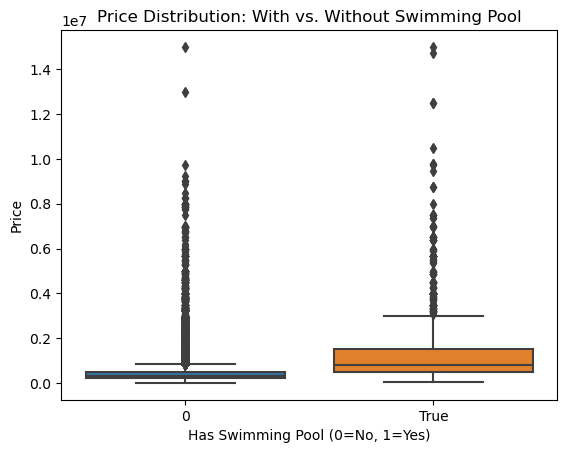

In [9]:
# make a boxplot
sns.boxplot(data=df_swim, x='swimmingPool_filled', y='price')
plt.title("Price Distribution: With vs. Without Swimming Pool")
plt.xlabel("Has Swimming Pool (0=No, 1=Yes)")
plt.ylabel("Price")
plt.show()